In [1]:
# # Zombie Outbreak
# ```@raw html
# <video width="auto" controls autoplay loop>
# <source src="https://raw.githubusercontent.com/JuliaDynamics/JuliaDynamics/master/videos/agents/zombies.mp4?raw=true" type="video/mp4">
# </video>
# ```
#
# This model showcases an ABM running on a map, using [`OpenStreetMapSpace`](@ref).
#
# ## Constructing the end of days
using Agents
using Random
using OpenStreetMapX


# We'll simulate a zombie outbreak in a city. To do so, we start with an agent which
# satisfies the OSMSpace conditions of having a `pos`ition of type
# `Tuple{Int,Int,Float64}`. For simplicity though we shall build this with the [`@agent`](@ref)
# macro.

@agent Zombie OSMAgent begin
    infected::Bool
end

# To be explicit, this macro builds the following type:
# ```julia
#mutable struct Zombie <: AbstractAgent
#    id::Int
#    pos::Tuple{Int,Int,Float64}
#    route::Vector{Int}
#    destination::Tuple{Int,Int,Float64}
#    infected::Bool
#end
# ```
# where a tuple `(i, j, x)::Tuple{Int,Int,Float64}` means a position
# on the road between nodes `i, j` of the map, having progressed `x` distance along the road.

In [8]:
function initialise(; map_path = "guanajuato.osm")
    model = ABM(Zombie, OpenStreetMapSpace("guanajuato.osm"))

    for id in 1:100
        start = random_position(model) # At an intersection
        finish = OSM.random_road_position(model) # Somewhere on a road
        route = OSM.plan_route(start, finish, model)
        human = Zombie(id, start, route, finish, false)
        add_agent_pos!(human, model)
    end
    # We'll add patient zero at a specific (latitude, longitude)
    start = OSM.road((21.020528683945823, -101.26631337301176), model)
    finish = OSM.intersection((21.020528683945823, -101.26631337301176), model)
    route = OSM.plan_route(start, finish, model)
    # This function call creates & adds an agent, see `add_agent!`
    zombie = add_agent!(start, model, route, finish, true)
    return model
end

initialise (generic function with 1 method)

In [3]:
function agent_step!(agent, model)
    # Each agent will progress 25 meters along their route
    move_along_route!(agent, model, 25)

    if is_stationary(agent, model) && rand(model.rng) < 0.1
        # When stationary, give the agent a 10% chance of going somewhere else
        OSM.random_route!(agent, model)
        # Start on new route
        move_along_route!(agent, model, 25)
    end

    if agent.infected
        # Agents will be infected if they get within 50 meters of a zombie.
        map(i -> model[i].infected = true, nearby_ids(agent, model, 50))
    end
end

agent_step! (generic function with 1 method)

In [4]:
using OpenStreetMapXPlot
using Plots
gr()

Plots.GRBackend()

In [5]:
ac(agent) = agent.infected ? :green : :black
as(agent) = agent.infected ? 6 : 5

function plotagents(model)
    ids = model.scheduler(model)
    colors = [ac(model[i]) for i in ids]
    sizes = [as(model[i]) for i in ids]
    markers = :circle
    pos = [OSM.map_coordinates(model[i], model) for i in ids]

    scatter!(
        pos;
        markercolor = colors,
        markersize = sizes,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
end

plotagents (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\Homar\Documents\Jupyter Notebooks\Zombies ABM\outbreak.gif
└ @ Plots C:\Users\Homar\.julia\packages\Plots\AJMX6\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Homar\\Documents\\Jupyter Notebooks\\Zombies ABM\\outbreak.gif")
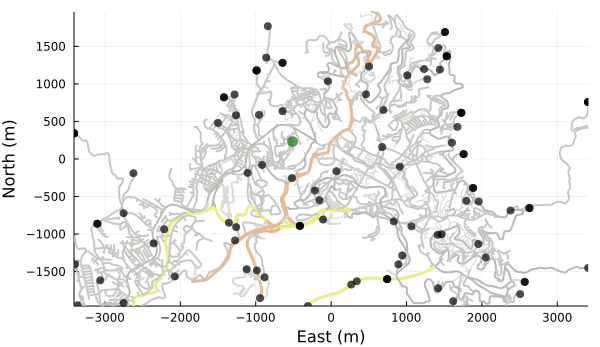

In [9]:
model = initialise()

frames = @animate for i in 0:300
    i > 0 && step!(model, agent_step!, 1)
    plotmap(model.space.m)
    plotagents(model)
end

gif(frames, "outbreak.gif", fps = 15)

In [ ]:
# The model constructor we build consists of a map, and 100 agents scattered randomly
# around it. They have their own agenda and need to travel to some new destination.
# Unfortunately one of the population has turned and will begin infecting anyone who
# comes close.

function initialise(; seed = 1234)
    #map_path = get_map_data();
    properties = Dict(:dt => 1 / 60)
    model = ABM(
        Zombie,
        OpenStreetMapSpace("guanajuato.osm");
        properties = properties,
        rng = Random.MersenneTwister(seed)
    )

    for id in 1:100
        start = random_position(model) # At an intersection
        speed = rand(model.rng) * 5.0 + 2.0 # Random speed from 2-7kmph
        human = Zombie(id, start, false, speed)
        add_agent_pos!(human, model)
        OSM.plan_random_route!(human, model; limit = 50) # try 50 times to find a random route
    end
    ## We'll add patient zero at a specific (latitude, longitude)
    start = OSM.nearest_road((21.02052069494164, -101.26651658125215), model)
    finish = OSM.nearest_node((21.02052069494164, -101.26651658125215), model)
    
    speed = rand(model.rng) * 5.0 + 2.0 # Random speed from 2-7kmph
    zombie = add_agent!(start, model, true, speed)
    plan_route!(zombie, finish, model)
    ## This function call creates & adds an agent, see `add_agent!`
    return model
end

In [ ]:
# In our model, zombies are seemingly oblivious to their state, since they keep going about their
# business, but start eating people along the way. Perhaps they can finally express their distaste
# for city commuting.

function agent_step!(agent, model)
    ## Each agent will progress along their route
    ## Keep track of distance left to move this step, in case the agent reaches its
    ## destination early
    distance_left = move_along_route!(agent, model, agent.speed * model.dt)

    if is_stationary(agent, model) && rand(model.rng) < 0.1
        ## When stationary, give the agent a 10% chance of going somewhere else
        OSM.plan_random_route!(agent, model; limit = 50)
        ## Start on new route, moving the remaining distance
        move_along_route!(agent, model, distance_left)
    end

    if agent.infected
        ## Agents will be infected if they get too close (within 10m) to a zombie.
        map(i -> model[i].infected = true, nearby_ids(agent, model, 0.01))
    end
    return
end

In [ ]:
# ## Visualising the fall of humanity
#
# Plotting this space in a seamless manner is a work in progress. For now we
# use [OSMMakie.jl](https://github.com/fbanning/OSMMakie.jl) and
# a custom routine.

# using OSMMakie
using CairoMakie
ac(agent) = agent.infected ? :green : :black
as(agent) = agent.infected ? 6 : 5

model = initialise()

# fig, ax, plot = osmplot(model.space.map)
ids = model.scheduler(model)
colors = Node([ac(model[i]) for i in ids])
sizes = Node([as(model[i]) for i in ids])
marker = :circle
pos = Node(Point2f[OSM.latlon(model[i].pos, model) for i in ids])
fig, _= scatter(pos; color = colors, size = sizes, marker)

record(fig, "outbreak.mp4", 1:200; framerate = 15) do i
    Agents.step!(model, agent_step!, 1)
    ids = model.scheduler(model)
    colors[] = [ac(model[i]) for i in ids]
    sizes[] = [as(model[i]) for i in ids]
    pos[] = Point2f[OSM.latlon(model[i].pos, model) for i in ids]
end